In [1]:
import sys
sys.path.append('../')

# Diving into scans-preprocessing with RadIO

## Quick reminder

Hello again! This is the second tutorial in the series, dedicated to the lung cancer research with RadIO. In the [first notebook](link-on-first) we talked about using RadIO to create a `Dataset` of scans from [LUNA16 competition dataset](https://luna16.grand-challenge.org/). In short, `Dataset` simplifies operating with large datasets that cannot fit in memory (see more [here](link-on-dataset)). Setting up a `Dataset` takes only several lines of code:

In [6]:
from radio.dataset import FilesIndex, Dataset
from radio import CTImagesMaskedBatch

LUNA_MASK = '/data/MRT/luna/s*/*.mhd'                                      # set glob-mask for scans from Luna-dataset here
luna_index = FilesIndex(path=LUNA_MASK, no_ext=True)                       # preparing indexing structure
luna_dataset = Dataset(index=luna_index, batch_class=CTImagesMaskedBatch)

We've also seen how easy it is to build simple preprocessing pipelines, that include `load` of data from disk and `resize` of scans to differrent shape:

In [12]:
from radio.dataset import Pipeline
preprocessing = (Pipeline()                      # initialize empty workflow
                 .load(fmt='raw')                # add load of scans from MetaImage to the workflow
                 .resize(shape=(92, 256, 256)))  # add resize to a shape to the workflow. Nothing is computed here,
                                                 # the whole thing is lazy!

..and generate a batch with 3 loaded and resized scans: 

In [4]:
batch = (luna_dataset >> preprocessing).next_batch(3)  # pass a batch of luna-scans of size 3 through the workflow 

In this tutorial we are diving deeper into preprocessing with RadIO. We will cover actions that allow to considerably augment Luna-dataset. `sample_nodules` - action, that samples cancerous/non-cancerous scan-crops, `unify_spacing`, `rotate`, `central_crop` are among actions, that help to perform augmentation. What's more, we will cover actions `create_mask` and `fetch_nodules_info`, that will help you to transform with ease [Luna cancer annotations](link-on-annots) into *cancerous masks*, **target (Y)** for segmenting nets (think of [Vnet](Vnet-link)). In short, after reading this tutorial you will be able to prepare a large and augmented dataset of crops for training [Vnet](Vnet-link).

## Augmentation of Luna


###  `unify_spacing`: alternative to `resize`

Not infrequently, scans in the dataset have drastically different scales. Take a look at two slices from different scans below: 

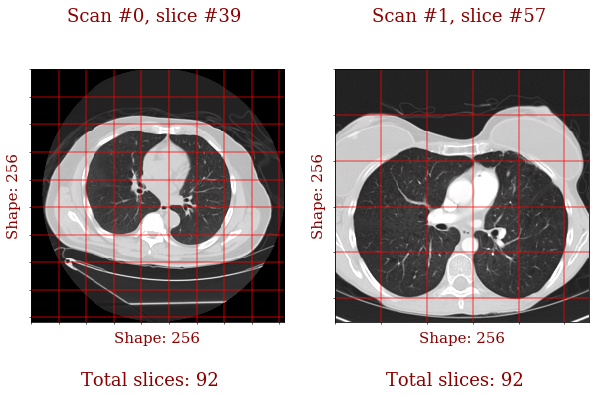

In [13]:
from utils import show_slices
import numpy as np
ixs = np.array(['1.3.6.1.4.1.14519.5.2.1.6279.6001.219618492426142913407827034169',
                '1.3.6.1.4.1.14519.5.2.1.6279.6001.185154482385982570363528682299'])
two_scans_dataset = Dataset(index=luna_index.create_subset(ixs), batch_class=CTImagesMaskedBatch)
batch = (two_scans_dataset >> preprocessing).next_batch(2)      # pass a batch through the workflow
show_slices(batch, scan_indices=[0, 1], ns_slice=[39, 57], grid=True)

As you can see, lungs on the right scan are clearly bigger than on the left one. In this case you may say that left and right scans have different **spacings**: the distance between adjacent pixels on the left scan is larger than on the right one. This is demonstrated by grids on both plots: the number of pixels to define 5 cm of the *real-world distance* is lesser for the left scan. 

In all, **Luna-dataset** incorporates variability, that is related to peculiarities of *data representation*, rather than *structural differences.* Gladly, with action `unify_spacing` from RadIO you can easily make the scans more isotropic, thus eliminating needless variability from the dataset:

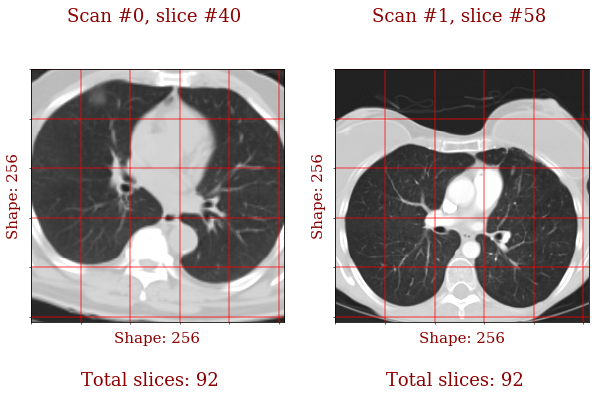

In [55]:
preprocessing = preprocessing.unify_spacing(spacing=(3.5, 1.0, 1.0), shape=(92, 256, 256))    
batch = (two_scans_dataset >> preprocessing).next_batch(2)
show_slices(batch, scan_indices=[0, 1], ns_slice=[40, 58], grid=True)

### `unify_spacing` as an agumenting action

So, how `unify_spacing` is an augmenting action? The idea is to slightly modify spacings of scans between different runs of `next_batch`. This allows to *controllably* introduce variability in the dataset. Say, you want the spacing to be randomly chosen from small set of predefined options. Assume, these options are

In [355]:
spacing_options = [(3.5, 0.5, 0.5), (3.5, 1.0, 1.0), (3.5, 1.5, 1.5), (3.5, 2.0, 2.0)]

The first step is to define *spacing randomizer*, a function that randomly fetches spacing:

In [361]:
spacing_randomizer = lambda: spacing_options[np.random.choice(range(len(spacing_options)))]

In [396]:
spacing_randomizer()

(3.5, 1.5, 1.5)

You can now set up the pipeline that generates random spacing for each run of `next_batch`.

In [366]:
from radio.dataset import F                                                         # see below the explanation
augmenting_pipeline = (Pipeline()                                                   # empty workflow
                       .load(fmt='raw')                                             # load scans
                       .unify_spacing(spacing=F(spacing_randomizer), shape=(92, 256, 256))
                      )

Note that spacing-parameter is set to `F(spacing_randomizer)`. Literally, this means the following: for each batch, passing through `augmenting_pipeline`, the spacing-argument is to be computed by the function `spacing_randomizer`(`F` stands for `F`unction). Pass the same batch through the workflow twice and see the result by yourself:

In [397]:
two_scans_pipeline = (two_scans_dataset >> augmenting_pipeline)  # new pipeline associated with dataset of two scans
batch_1 = two_scans_pipeline.next_batch(2, n_epochs=None)        # n_epochs=None means that the next_batch-generator
batch_2 = two_scans_pipeline.next_batch(2)                       # works for infinite number of epochs

In [314]:
np.random.choice(range(3))

2

In [197]:
from radio.dataset import F
radom_spacing = lambda x: return 

### some more augmenting actions

### preparing a target-tensor for a segmenting net

In [200]:
from radio.dataset import C, action, F, V

In [368]:
class CTImagesCustomBatch(CTImagesMaskedBatch):
    @action
    def to_interval(self, interval):
        self.normalize_hu()
        self.images = self.images * (interval[1] - interval[0]) / 255 + interval[0]
        return self
    
    @action
    def get_min_max(self, lst):
        print(id(lst))
        print(lst)
        min_max_tuple = (self.images.min(), self.images.max()) 
        lst[0] = min_max_tuple
        print(lst)
        return self

In [369]:
min_max = lambda *args: sorted(np.random.uniform(low=1, high=10, size=2))

In [370]:
min_max()

[1.5227525095137953, 8.795585311974417]

In [371]:
id(acums)

140129115212296

In [392]:
pipey = (Pipeline()
         .load(fmt='blosc')
         .init_variable('acums', [0])
         .to_interval(interval=F(min_max))
         .get_min_max(V('acums'))
         )

In [387]:
bloscix = FilesIndex(path='/data/lunaset_split_new/train/cancer/*', dirs=True)
bloscset = Dataset(index=bloscix, batch_class=CTImagesCustomBatch)

In [393]:
pipey = bloscset >> pipey
bch = pipey.next_batch(3)

140128782593608
[0]
[(7.9312411390664384, 9.6210187139559711)]


In [211]:
pipey.get_variable('acums')

[(2.2083817657606364, 7.9064876738069856)]

In [301]:
cally = np.random.rand

In [302]:
def inplace_eval(args):
    if isinstance(args, list):
        for i in range(len(args)):
            args[i] = inplace_eval(args[i])
        return args
    elif callable(args):
        return args()
    else:
        return args
        

In [303]:
lst = [1, 2, cally]

In [304]:
inplace_eval(lst)

[1, 2, 0.8910997895280472]

In [305]:
lst

[1, 2, 0.8910997895280472]